In [1]:
import pandas as pd
import numpy as np

import os
import sys
import pickle
import librosa
import librosa.display

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder , LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from IPython.display import Audio
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 


In [2]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [3]:
trdata=pd.read_csv('C:\All_Files\BE Project\\trials\Finalised\RTSH cnnfeatures.csv')

In [4]:
trdata.shape

(10958, 163)

In [5]:
trdata.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '153', '154', '155', '156', '157', '158', '159', '160', '161',
       'labels'],
      dtype='object', length=163)

In [6]:
X = trdata.drop('labels', axis = 1).values
Y = trdata['labels'].values

In [7]:
X.shape,Y.shape

((10958, 162), (10958,))

In [8]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [9]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((8218, 162), (8218, 8), (2740, 162), (2740, 8))

In [10]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((8218, 162), (8218, 8), (2740, 162), (2740, 8))

In [11]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((8218, 162, 1), (8218, 8), (2740, 162, 1), (2740, 8))

In [12]:
model=Sequential()
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 4, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 4, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 4, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 4, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 64)           384       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 41, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 41, 128)           41088     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 128)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 11, 128)           82048     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 3, 128)           0

In [14]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=2, patience=5, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
257/257 [==============================] - 4s 15ms/step - loss: 0.4252 - accuracy: 0.8466 - val_loss: 0.6053 - val_accuracy: 0.8015 - lr: 0.0010
Epoch 2/50
257/257 [==============================] - 3s 12ms/step - loss: 0.4140 - accuracy: 0.8514 - val_loss: 0.6548 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 3/50
257/257 [==============================] - 3s 12ms/step - loss: 0.3746 - accuracy: 0.8604 - val_loss: 0.6700 - val_accuracy: 0.8004 - lr: 0.0010
Epoch 4/50
257/257 [==============================] - 3s 12ms/step - loss: 0.3725 - accuracy: 0.8671 - val_loss: 0.6530 - val_accuracy: 0.8062 - lr: 0.0010
Epoch 5/50
257/257 [==============================] - 3s 13ms/step - loss: 0.3367 - accuracy: 0.8795 - val_loss: 0.6513 - val_accuracy: 0.7985 - lr: 0.0010
Epoch 6/50
257/257 [==============================] - 3s 11ms/step - loss: 0.3408 - accuracy: 0.8807 - val_loss: 0.6415 - val_accuracy: 0.7996 - lr: 0.0010
Epoch 7/50
257/257 [==============================] - 3s 13ms/st

86/86 [==============================] - 0s 4ms/step - loss: 1.1508 - accuracy: 0.8599
Accuracy of our model on test data :  85.98540425300598 %


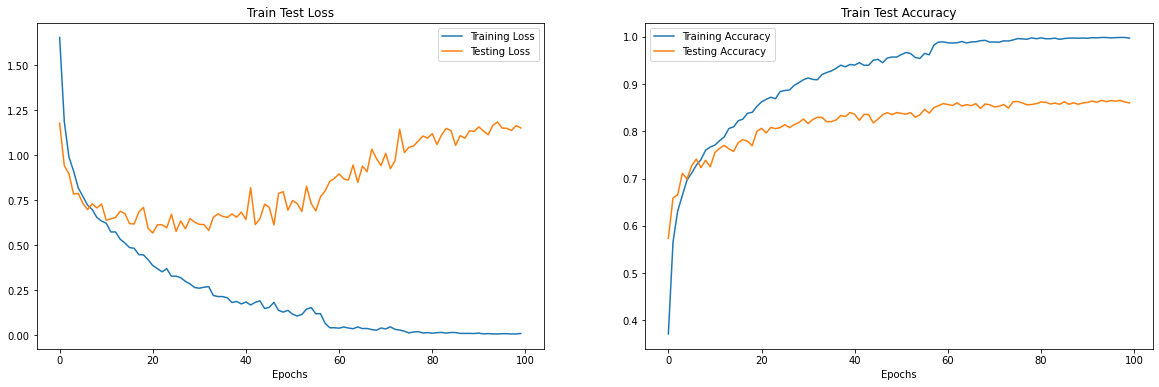

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Train Test Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Train Test Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [15]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [16]:
#model.save("RTSH CNN epox.h5")

In [17]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,neutral,neutral
1,disgust,disgust
2,happy,happy
3,fear,fear
4,sad,fear
5,disgust,disgust
6,sad,sad
7,happy,happy
8,disgust,disgust
9,sad,sad


In [20]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

'''# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)'''

'# taking any example and checking for techniques.\npath = np.array(data_path.Path)[1]\ndata, sample_rate = librosa.load(path)'

In [21]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    '''noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically'''
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [46]:
filename="C:\All_Files\BE Project\Ravdess\RavdessSong\Actor_02\\03-02-03-02-01-01-02.wav"
data, sample_rate = librosa.load(filename, res_type='kaiser_fast')

# ZCR
result = np.array([])
zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
result=np.hstack((result, zcr)) # stacking horizontally

# Chroma_stft
stft = np.abs(librosa.stft(data))
chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
result = np.hstack((result, chroma_stft)) # stacking horizontally

# MFCC
mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
result = np.hstack((result, mfcc)) # stacking horizontally

# Root Mean Square Value
rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
result = np.hstack((result, rms)) # stacking horizontally

# MelSpectogram
mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
result = np.hstack((result, mel)) # stacking horizontally

'''mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)'''


#mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
'''print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)'''

'''predicted_label=model.predict(result)
print(predicted_label)
classes_x=np.argmax(predicted_label,axis=1)
prediction_class = labelencoder.inverse_transform(classes_x)
prediction_class'''

'predicted_label=model.predict(result)\nprint(predicted_label)\nclasses_x=np.argmax(predicted_label,axis=1)\nprediction_class = labelencoder.inverse_transform(classes_x)\nprediction_class'

In [ ]:
predicted_label=model.predict(result)
print(predicted_label)
classes_x=np.argmax(predicted_label,axis=1)
prediction_class = labelencoder.inverse_transform(classes_x)
prediction_class

In [1]:
result.shape
result = np.expand_dims(result, axis=1)

NameError: name 'result' is not defined

In [48]:
result.shape

(162, 1)

In [49]:
predicted_label=model.predict(result)

In [50]:
dic = {0:'angry',1: 'calm',2: 'disgust',3: 'fear',4: 'happy', 5:'neutral',6:'sad',7:'surprise'}
classes_x=np.argmax(predicted_label,axis=1)
accuracy=float(np.max(predicted_label,axis=1)[0])
print("Accuracy: ",accuracy*100 ,"%")
print(dic[classes_x[0]])

Accuracy:  52.430713176727295 %
disgust
